In [4]:
import json
import pandas as pd
import cv2
import numpy as np
from enum import Enum, auto
import sys
import torch
import matplotlib.pyplot as plt


sys.path.append("../Skin_segmentation")
sys.path.append('../../Models')

from Skindetector import *
from rPPGNet import rPPGNet

def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 
            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list


root_dir = "/work3/s174159/data/"
video_file = root_dir + "00/02/c920-1.avi"
bb_file = root_dir + "bbox/00/02/c920-1.face"
ecg_path = root_dir + "00/02/viatom-raw.csv"
index_path = root_dir + "00/02/c920.csv"

bb_data =  pd.read_csv(bb_file, sep=" ", header=None, names=["frame", "x", "y", "w", "h"]).drop("frame", axis=1)
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
ecg = pd.read_csv(ecg_path)

In [126]:
import cv2
from IPython.display import display, Image

# Define the VideoCapture object and VideoWriter
output_file = 'output_video.mp4'
video = cv2.VideoCapture(video_file)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
out = cv2.VideoWriter(output_file, fourcc, 30, (128, 128) ) # 30 is the frames per second, (128, 128) is the frame size

display_handle = display(None, display_id=True)
i = 0

bounded_frames = []

try:
    while True:
        ret, frame = video.read()
        if not ret:  # Check if there are no more frames
            print("Finished video...")
            break  # Exit the loop if there are no more frames
        
        if i == len(data):
            i = 0
        x, y, w, h = bb_data.iloc[i].values.astype(int)
        i += 1
        frame_bb = frame[y:y + h, x:x + w]
        frame_bb = cv2.resize(frame_bb, (128, 128), interpolation=cv2.INTER_AREA)
        bounded_frames.append(np.array(frame_bb, dtype='float32'))
        #detector = SkinDetector(frame_bb)
        #detector.find_skin()
        #image, mask, skin = detector.get_resulting_images()
        
        # Save the processed frame to the output video
        #out.write(frame)
        
        #_, frame = cv2.imencode('.jpeg', frame)
        #display_handle.update(Image(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()
    out.release()  # Release the VideoWriter
    display_handle.update(None)


None

Finished video...


In [127]:
frame_tensor = torch.tensor(np.array(bounded_frames[1:65]))
frame_tensor = torch.swapaxes(frame_tensor, 0, 3)
frame_tensor = torch.swapaxes(frame_tensor, 1, 3)

In [133]:
frame_tensor.unsqueeze(0).shape

torch.Size([1, 3, 64, 128, 128])

In [135]:
skin_map, rPPG_aux, rPPG, rPPG_SA1, rPPG_SA2, rPPG_SA3, rPPG_SA4, x_visual6464, x_visual3232 = model(frame_tensor.unsqueeze(0))

In [1]:
def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 

            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list

            return final_list

In [22]:
ecg
idx = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
idx

,timestamp,idx_sig
0,1523631753577,4955
1,1523631753620,4960
2,1523631753643,4965
3,1523631753676,4970
4,1523631753707,4975
...,...,...
1795,1523631813486,12445
1796,1523631813513,12450
1797,1523631813560,12455
1798,1523631813582,12460


In [23]:
from ecgdetectors import Detectors
fs=250
detectors = Detectors(fs)
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg = ecg.iloc[int(idx.iloc[1].idx_sig/5):][:65*2] 
#r_peaks = detectors.two_average_detector(ecg[" ECG"])

IndexError: index 130 is out of bounds for axis 0 with size 130

In [17]:
r_peaks

[82, 329, 509, 811, 1639]

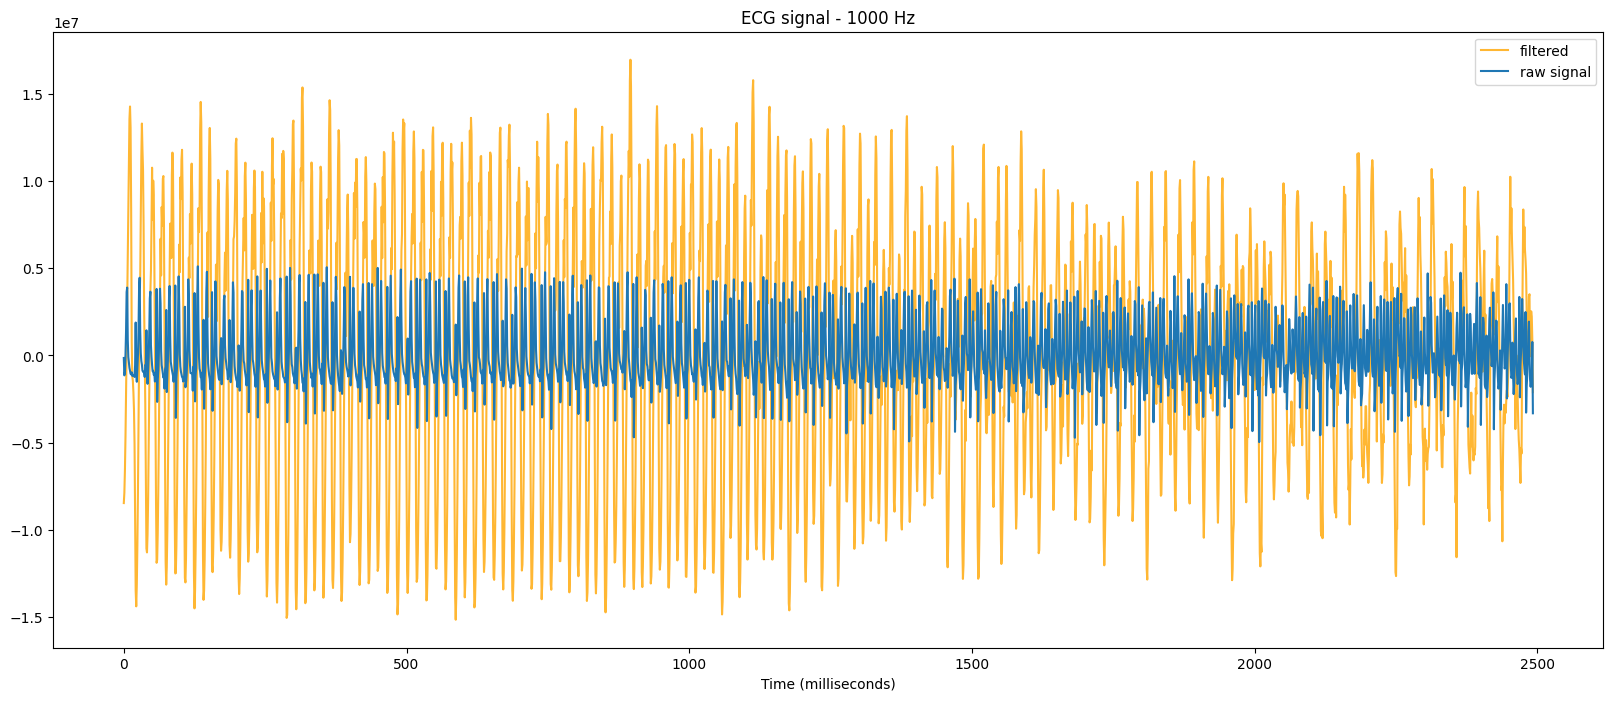

In [ ]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg = pd.read_csv(ecg_path)
ecg = ecg.groupby(by="milliseconds", as_index=False).mean()
ecg_transformed = np.correlate(ecg[" ECG"], peak_filter, mode="same")
plt.figure(figsize=(20,8))
plt.title('ECG signal - 1000 Hz')
plt.plot(ecg_transformed, alpha = 0.8, c='orange')
plt.plot(ecg[" ECG"], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

In [20]:
ecg = pd.read_csv(ecg_path)
#ecg

In [1]:
im
plt.plot(ecg[" ECG HR"])

NameError: name 'plt' is not defined

In [ ]:
import scipy


In [544]:
model_output = [0.9420, 1.0000, 0.9986, 0.9438, 0.7974, 0.5907, 0.4464, 0.4006, 0.4038,
         0.4085, 0.4105, 0.4096, 0.4125, 0.4279, 0.4473, 0.4662, 0.4787, 0.4862,
         0.4876, 0.4833, 0.4733, 0.4515, 0.3992, 0.3224, 0.2237, 0.1271, 0.0551,
         0.0119, 0.0000, 0.0172, 0.0438, 0.0643, 0.0802, 0.0916, 0.0962, 0.1023,
         0.1115, 0.1238, 0.1339, 0.1407, 0.1503, 0.1693, 0.2010, 0.2513, 0.3122,
         0.3705, 0.4194, 0.4592, 0.4903, 0.5102, 0.5169, 0.5053, 0.4876, 0.4650,
         0.4384, 0.4050, 0.3621, 0.3051, 0.2467, 0.1985, 0.1714, 0.1635, 0.1925,
         0.4493]


target = [0.2500, 0.3098, 0.3397, 0.3098, 0.2908, 0.3043, 0.3016, 0.2853, 0.2853,
         0.2853, 0.2690, 0.4810, 0.4810, 0.2636, 0.2717, 0.2989, 0.3424, 0.3288,
         0.2717, 0.2364, 0.2065, 0.1549, 0.1060, 0.1087, 0.1168, 0.1087, 0.4239,
         0.4293, 0.1277, 0.1386, 0.1576, 0.2065, 0.2364, 0.2065, 0.1793, 0.1766,
         0.1685, 0.1549, 0.1658, 0.1685, 0.1603, 0.4891, 0.4973, 0.1766, 0.1739,
         0.2011, 0.2500, 0.2772, 0.2473, 0.2147, 0.2120, 0.2011, 0.1875, 0.1984,
         0.1984, 0.1875, 0.5380, 0.5435, 0.1984, 0.2120, 0.2446, 0.2908, 0.3125,
         0.2908]
import numpy as np
model_output1 = (model_output - np.min(model_output)) / (np.max(model_output ) - np.min(model_output))
model_output2 = (model_output-np.mean(model_output)) /np.std(model_output)	

In [492]:
model_output = np.array([108.4256,  92.1672,   0.0000,  95.9657, 156.0000, 110.3268, 104.8805,
         104.8362, 104.8141, 104.8244, 104.8278, 104.8299, 104.8464, 104.8696,
         104.8311, 104.8186, 104.8297, 104.8300, 104.8500, 104.8472, 104.8141,
         104.8089, 104.8410, 104.8363, 104.7937, 104.7955, 104.8534, 104.8579,
         104.8292, 104.8305, 104.8325, 104.7972, 104.8210, 104.8597, 104.8377,
         104.8042, 104.8252, 104.8600, 104.8552, 104.8151, 104.8205, 104.8552,
         104.8373, 104.8388, 104.8570, 104.8303, 104.8318, 104.8455, 104.8538,
         104.8637, 104.7841, 104.8265, 104.8678, 104.8340, 104.8454, 104.8370,
         104.8350, 104.8337, 104.8196, 104.8391, 104.7996, 104.8463, 104.7960,
         104.8841])
gt = np.array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
         100., 100., 100., 100., 100., 101., 101., 101., 101., 101., 101., 101.,
         101., 101., 101., 101.])

mses = np.sqrt(((model_output-gt)**2).mean())
mses

15.130371736531295

In [560]:
r_peaks

array([ 1, 10, 18, 50])

array([0.942 , 1.    , 0.9986, 0.9438, 0.7974, 0.5907, 0.4464, 0.4006,
       0.4038, 0.4085, 0.4105, 0.4096, 0.4125, 0.4279, 0.4473, 0.4662,
       0.4787, 0.4862, 0.4876, 0.4833, 0.4733, 0.4515, 0.3992, 0.3224,
       0.2237, 0.1271, 0.0551, 0.0119, 0.    , 0.0172, 0.0438, 0.0643,
       0.0802, 0.0916, 0.0962, 0.1023, 0.1115, 0.1238, 0.1339, 0.1407,
       0.1503, 0.1693, 0.201 , 0.2513, 0.3122, 0.3705, 0.4194, 0.4592,
       0.4903, 0.5102, 0.5169, 0.5053, 0.4876, 0.465 , 0.4384, 0.405 ,
       0.3621, 0.3051, 0.2467, 0.1985, 0.1714, 0.1635, 0.1925, 0.4493])

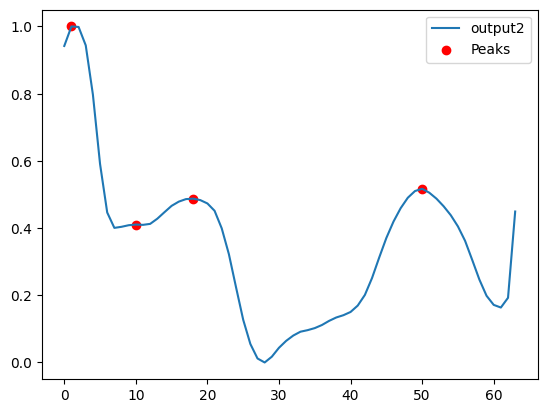

In [562]:
import matplotlib.pyplot as plt
#plt.plot(model_output, label="output1")
plt.plot(model_output1, label="output2")
peaks = [model_output1[i] for i in r_peaks]
plt.scatter(r_peaks, peaks, color='r', marker='o', label='Peaks')
#plt.plot(target, label="target")
plt.legend()

model_output1

In [546]:
model_output2 = torch.tensor((model_output-np.mean(model_output)) /np.std(model_output))

In [547]:
r_peaks = scipy.signal.find_peaks(model_output2)[0]
bpm = [25/(r_peaks[i+1]-r_peaks[i])*60 for i in range(len(r_peaks)-1)]
bpm = [int(x) for x in bpm]

In [548]:
r_peaks

array([ 1, 10, 18, 50])

In [549]:
bpm

[166, 187, 46]

In [550]:
edges = [r_peaks[0] + 0, 64 - r_peaks[-1]]
edges

[1, 14]

In [551]:
repeats = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks)-1)]
repeats[0] = repeats[0] + edges[0]
repeats[-1] = repeats[-1] + edges[1]

In [552]:
repeats

[10, 8, 46]

In [553]:
r_peaks

array([ 1, 10, 18, 50])

In [554]:
len(np.repeat(bpm, repeats))
bpms = np.repeat(bpm, repeats)

In [556]:
torch.tensor(bpms)

tensor([166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 187, 187, 187, 187,
        187, 187, 187, 187,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
         46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
         46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
         46,  46,  46,  46,  46,  46,  46,  46])

In [ ]:
np.sqrt(((model_output-gt)**2).mean())

In [512]:
r_peaks

array([ 1, 10, 18, 50])

In [513]:
model_output2

array([ 2.5075308 ,  2.75550685,  2.74952122,  2.51522661,  1.88930088,
        1.00556557,  0.38861827,  0.19280271,  0.20648415,  0.22657876,
        0.23512965,  0.23128175,  0.24368055,  0.30952247,  0.39246618,
        0.47327216,  0.52671528,  0.55878114,  0.56476677,  0.54638234,
        0.50362785,  0.41042306,  0.18681708, -0.1415374 , -0.56352422,
       -0.97653259, -1.28436492, -1.46906432, -1.51994216, -1.44640444,
       -1.3326775 , -1.24503079, -1.17705115, -1.12831103, -1.10864397,
       -1.08256373, -1.0432296 , -0.99064158, -0.94745954, -0.91838649,
       -0.87734218, -0.79610865, -0.66057691, -0.44552183, -0.18514698,
        0.06411169,  0.27318115,  0.44334402,  0.57631049,  0.66139192,
        0.69003743,  0.64044222,  0.56476677,  0.46814163,  0.35441468,
        0.21161468,  0.02819792, -0.21550267, -0.46518889, -0.67126554,
       -0.7871302 , -0.82090625, -0.69691823,  0.40101708])

In [519]:
bpm

[166, 187, 46]

In [517]:
64//len(bpm)

21

In [511]:
len(model_output2)

64

In [114]:
from ecgdetectors import Detectors
df = pd.read_csv(ecg_path)
lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]
df["Lead"] = lead_names * (len(df) // 5)
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000  # Convert time.
index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_signal"])
tmp_df = df[df["Lead"] == "Lead II"].loc[index_df.iloc[0].idx_signal+1:index_df.iloc[-1].idx_signal+1]
unfiltered_ecg = tmp_df[" ECG"]

In [296]:
from ecgdetectors import Detectors
detector = Detectors(25)
detector.

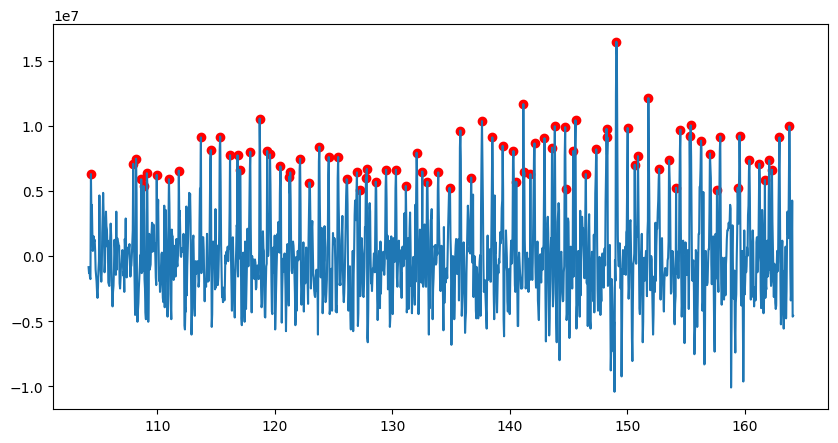

In [299]:
plt.figure(figsize=(10, 5))
plt.plot(tmp_df["time"], tmp_df.reset_index()[" ECG"])
peaks = [tmp_df.reset_index()[" ECG"][i] for i in r_peaks]
t_peaks = [tmp_df.reset_index()["time"][i] for i in r_peaks]
plt.scatter(t_peaks, peaks, color='r', marker='o', label='Peaks')
#plt.xlim(109, 120)

In [298]:
bpm=[25/(r_peaks[i+1]-r_peaks[i])*60 for i in range(len(r_peaks)-1)]
print("calculated mean BPM:", np.mean(bpm))
print("Ground Truth BPM", tmp_df[" ECG HR"].mean())

calculated mean BPM: 155.47169590431866
Ground Truth BPM 96.77933333333333


(9.0, 12.0)

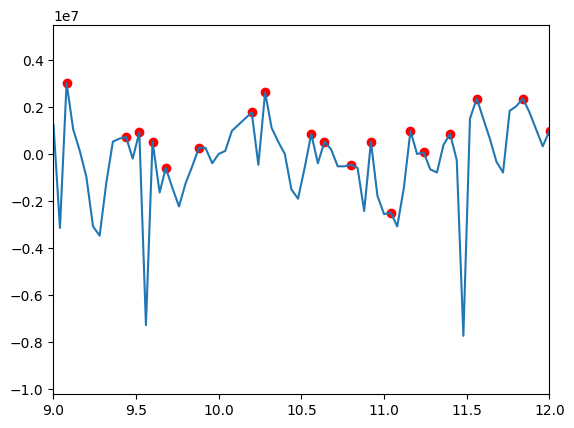

In [170]:

plt.plot(tmp_df["time"], tmp_df.reset_index()[" ECG"])
peaks = [tmp_df.reset_index()[" ECG"][i] for i in r_peaks]
t_peaks = [tmp_df.reset_index()["time"][i] for i in r_peaks]
plt.scatter(t_peaks, peaks, color='r', marker='o', label='Peaks')
plt.xlim(9, 12)
#plt.scatter(tmp_df[])

In [302]:
bpm=[25/(r_peaks[i+1]-r_peaks[i])*50 for i in range(len(r_peaks)-1)]
bpm

[13.88888888888889,
 208.33333333333334,
 113.63636363636364,
 250.0,
 178.57142857142858,
 59.523809523809526,
 48.07692307692308,
 59.523809523809526,
 26.595744680851062,
 59.523809523809526,
 62.5,
 59.523809523809526,
 78.125,
 250.0,
 56.81818181818182,
 62.5,
 78.125,
 208.33333333333334,
 56.81818181818182,
 65.78947368421053,
 625.0,
 59.523809523809526,
 62.5,
 59.523809523809526,
 62.5,
 62.5,
 69.44444444444444,
 56.81818181818182,
 208.33333333333334,
 96.15384615384616,
 625.0,
 65.78947368421053,
 56.81818181818182,
 59.523809523809526,
 59.523809523809526,
 54.347826086956516,
 104.16666666666667,
 113.63636363636364,
 54.347826086956516,
 52.083333333333336,
 54.347826086956516,
 54.347826086956516,
 54.347826086956516,
 56.81818181818182,
 56.81818181818182,
 54.347826086956516,
 208.33333333333334,
 83.33333333333334,
 625.0,
 96.15384615384616,
 138.88888888888889,
 59.523809523809526,
 78.125,
 208.33333333333334,
 56.81818181818182,
 625.0,
 83.33333333333334,
 25

In [191]:
ecg_test = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=80)
len(ecg_test)

15000

In [371]:
def moving_average(series, window_size=5):
            # Convert array of integers to pandas series 

            # Get the window of series 
            # of observations of specified window size 
            windows = series.rolling(window_size) 

            # Create a series of moving 
            # averages of each window 
            moving_averages = windows.mean() 

            # Convert pandas series back to list 
            moving_averages_list = moving_averages.tolist() 
            final_list = moving_averages_list
            return final_list

def detrend_ecg(ecg_signal, smoothing_parameter=300):
            return np.convolve(ecg_signal, np.ones(smoothing_parameter) / smoothing_parameter, mode='same')

In [8]:
ecg_path = root_dir + "00/04/viatom-raw.csv"
index_path = root_dir + "00/04/c920.csv"


index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
df = pd.read_csv(ecg_path)

lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]
df["Lead"] = lead_names * (len(df) // 5)
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000  # Convert time.
index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_signal"])
#df[" ECG"] = detrend_ecg(df[" ECG"], 300)
df["ECG_norm"] = (df[" ECG"] - np.min(df[" ECG"] )) / (np.max(df[" ECG"] ) - np.min(df[" ECG"] ))
df["ECG_MV"] = moving_average(df["ECG_norm"], 25) #moving average
tmp_df = df[df["Lead"] == "Lead II"]
unfiltered_ecg = tmp_df[" ECG"]

#tmp_df = tmp_df[tmp_df["Lead"] == "Lead II"]
tmp_df

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,Lead,time,ECG_norm,ECG_MV
1,1523624281149,-393216,86,-56,-1,-1,0,Lead II,0.000,0.368243,NaN
6,1523624281190,-65536,86,-56,-1,-1,0,Lead II,0.041,0.385135,NaN
11,1523624281230,589824,86,-56,-1,-1,0,Lead II,0.081,0.418919,NaN
16,1523624281269,1769472,86,-56,-1,-1,0,Lead II,0.120,0.479730,NaN
21,1523624281309,983040,86,-56,-1,-1,0,Lead II,0.160,0.439189,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9386,1523624356229,655360,-88,-56,-1,-1,0,Lead II,75.080,0.422297,0.341757
9391,1523624356269,-1376256,-88,-56,-1,-1,0,Lead II,75.120,0.317568,0.345000
9396,1523624356309,-1310720,-88,-56,-1,-1,0,Lead II,75.160,0.320946,0.345946
9401,1523624356349,-1310720,-88,-56,-1,-1,0,Lead II,75.200,0.320946,0.348243


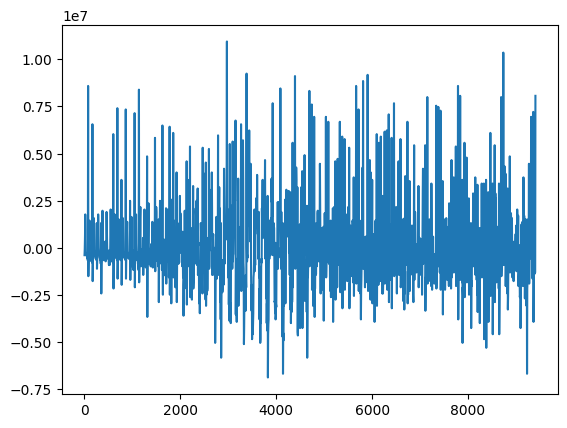

In [9]:
plt.plot(unfiltered_ecg)

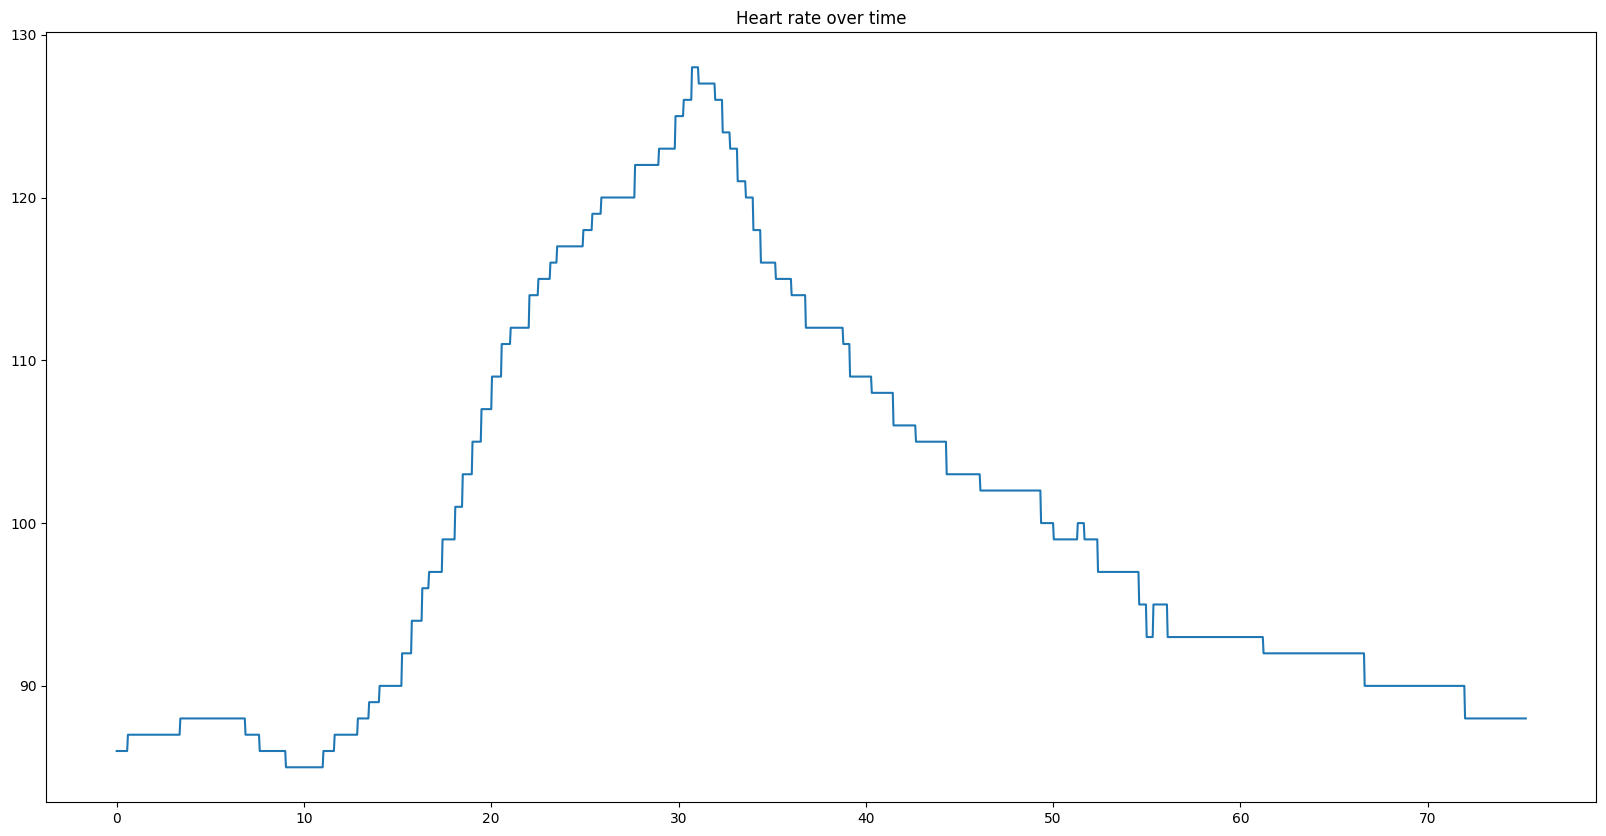

In [468]:
plt.figure(figsize=(20,10))
plt.title("Heart rate over time")
plt.plot(df["time"], abs(df[" ECG HR"]))
plt.show()

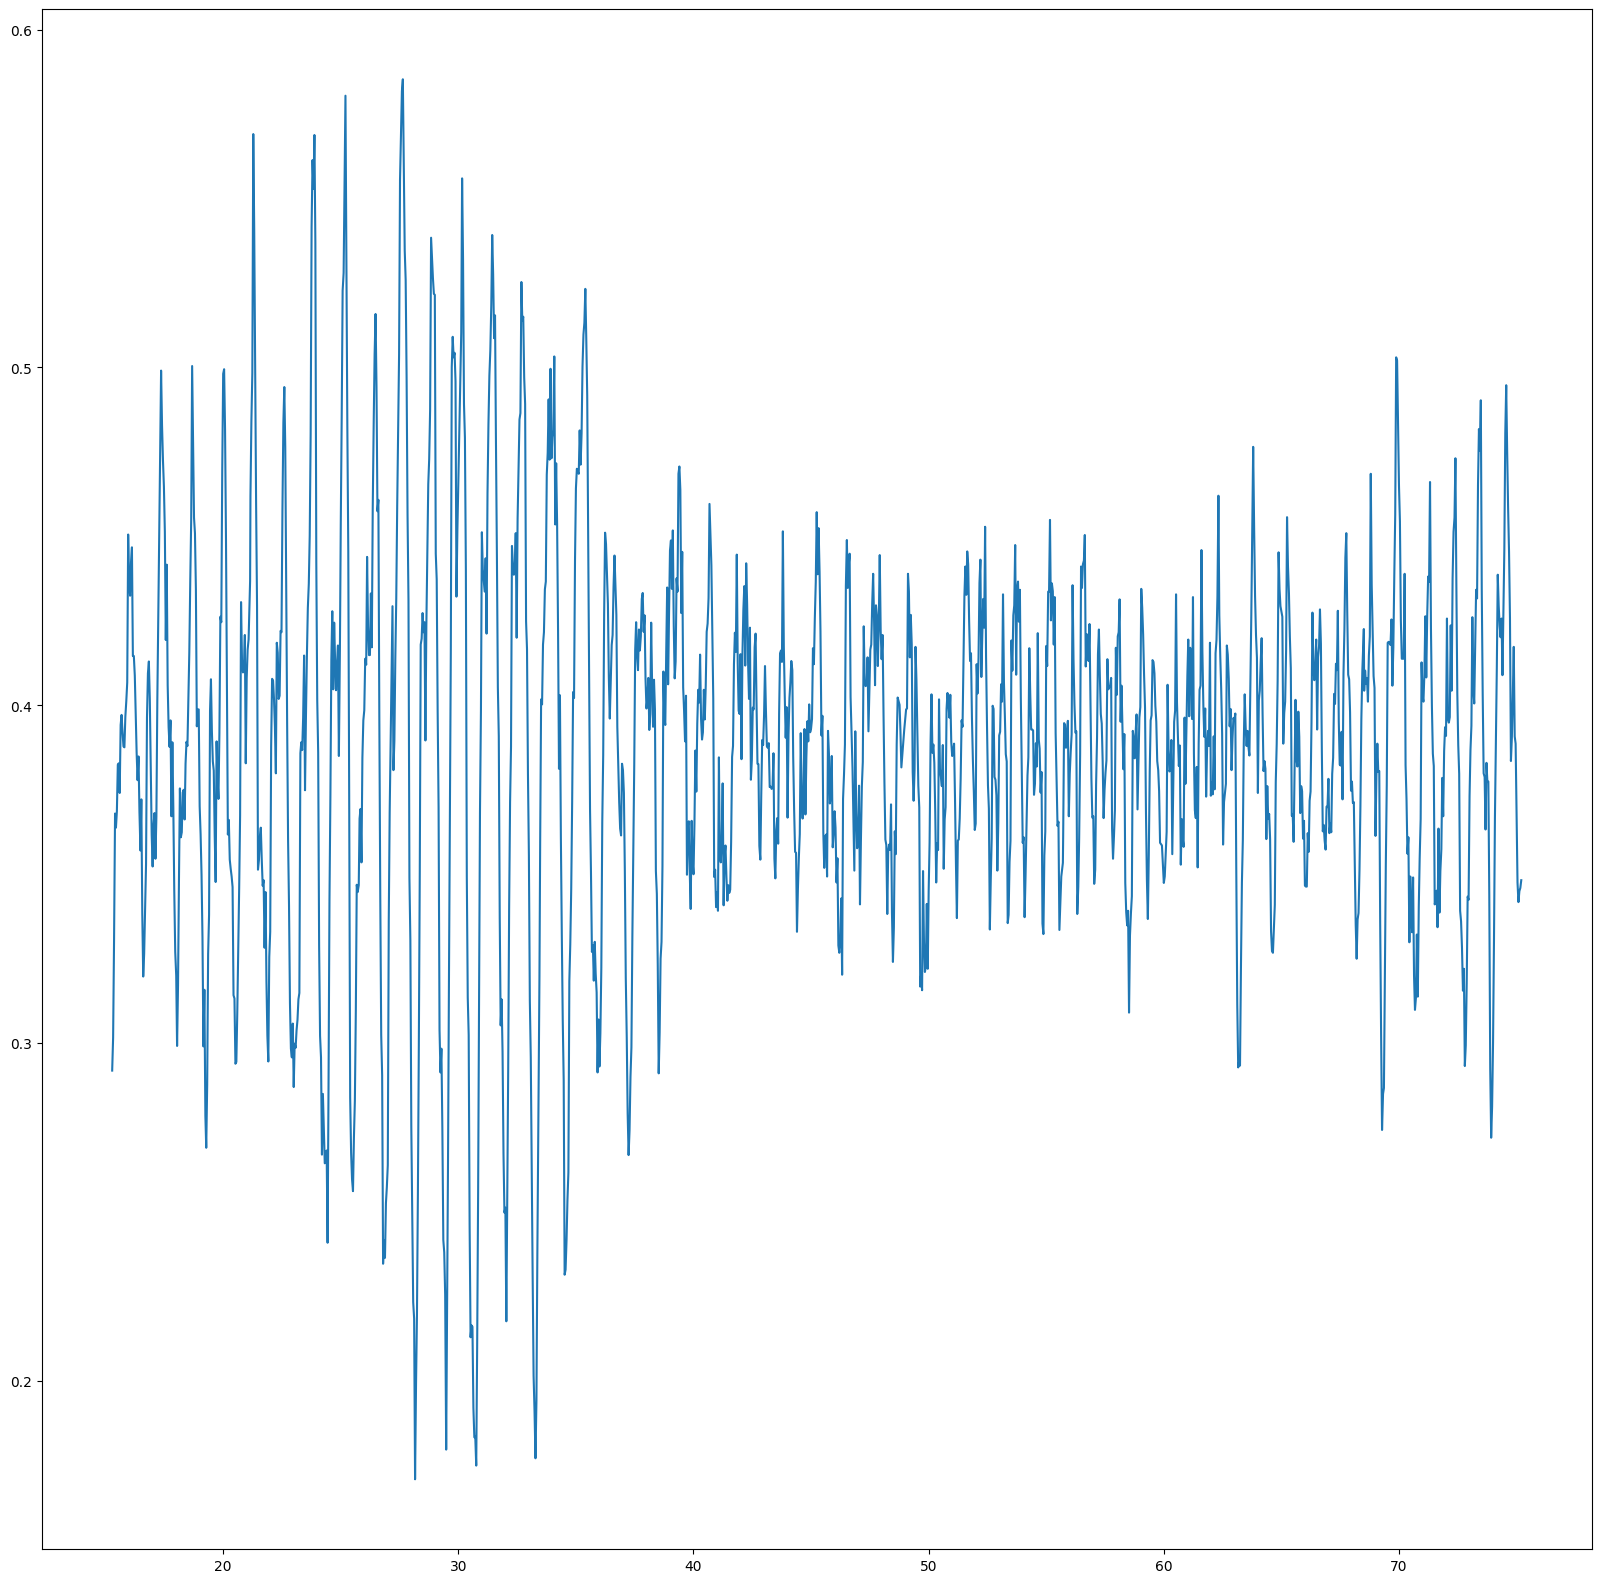

In [446]:
plt.figure(figsize=(20,20))
plt.plot(tmp_df["time"], tmp_df["ECG_MV"])
#plt.xlim(15, 25)

In [457]:
tmp_df.iloc[-1]["time"] - tmp_df.iloc[0]["time"]


59.919000000000004

In [448]:
peaks = scipy.signal.find_peaks(tmp_df["ECG_MV"])[0]
bpm = [25/(peaks[i+1] - peaks[i])*60 for i in range(len(peaks)-1)]
np.mean(bpm)

410.4675385289561

In [400]:
tmp_df["ECG_MV"]

1         -655.360000
6        -8628.906667
11      -21189.973333
16      -26760.533333
21       48278.186667
            ...      
9381     85087.573333
9386    162966.186667
9391    199120.213333
9396    225771.520000
9401    225553.066667
Name: ECG_MV, Length: 1881, dtype: float64

In [401]:
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=120)
ecg

array([1.14783082, 1.14117551, 1.12462083, ..., 1.00495924, 0.95946693,
       0.90627801])

In [431]:
sig[5:]

array([0.41932432, 0.41878378, 0.41283784, ..., 0.345     , 0.34594595,
       0.34824324])

In [432]:
sig = tmp_df["ECG_MV"][5:].values
signals, info = nk.ecg_process(sig, sampling_rate=25)
nk.ecg_plot(signals, info)

/work3/s180820/Eulerian_Magnificaiton/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work3/s180820/Eulerian_Magnificaiton/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/work3/s180820/Eulerian_Magnificaiton/.venv/lib/python3.11/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


ZeroDivisionError: integer division or modulo by zero

In [381]:
abs(tmp_df[" ECG HR"]).mean()

103.32354903268846

In [325]:
tmp_df

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,Lead,time
1911,1523624296430,-1114112,92,-56,-1,-1,0,Lead II,15.281
1916,1523624296470,-1376256,92,-56,-1,-1,0,Lead II,15.321
1921,1523624296510,3997696,92,-56,-1,-1,0,Lead II,15.361
1926,1523624296552,-2883584,92,-56,-1,-1,0,Lead II,15.403
1931,1523624296590,-1179648,92,-56,-1,-1,0,Lead II,15.441
...,...,...,...,...,...,...,...,...,...
9381,1523624356189,-262144,-88,-56,-1,-1,0,Lead II,75.040
9386,1523624356229,655360,-88,-56,-1,-1,0,Lead II,75.080
9391,1523624356269,-1376256,-88,-56,-1,-1,0,Lead II,75.120
9396,1523624356309,-1310720,-88,-56,-1,-1,0,Lead II,75.160


In [326]:
1500/30

50.0

In [330]:
tmp_df[tmp_df["time"] < 25]

,milliseconds,ECG,ECG HR,PPG,PPG HR,SpO2,PI,Lead,time
1911,1523624296430,-1114112,92,-56,-1,-1,0,Lead II,15.281
1916,1523624296470,-1376256,92,-56,-1,-1,0,Lead II,15.321
1921,1523624296510,3997696,92,-56,-1,-1,0,Lead II,15.361
1926,1523624296552,-2883584,92,-56,-1,-1,0,Lead II,15.403
1931,1523624296590,-1179648,92,-56,-1,-1,0,Lead II,15.441
...,...,...,...,...,...,...,...,...,...
3101,1523624305950,-393216,117,-56,-1,-1,0,Lead II,24.801
3106,1523624305990,-327680,117,-56,-1,-1,0,Lead II,24.841
3111,1523624306030,655360,117,-56,-1,-1,0,Lead II,24.881
3116,1523624306070,1507328,118,-56,-1,-1,0,Lead II,24.921


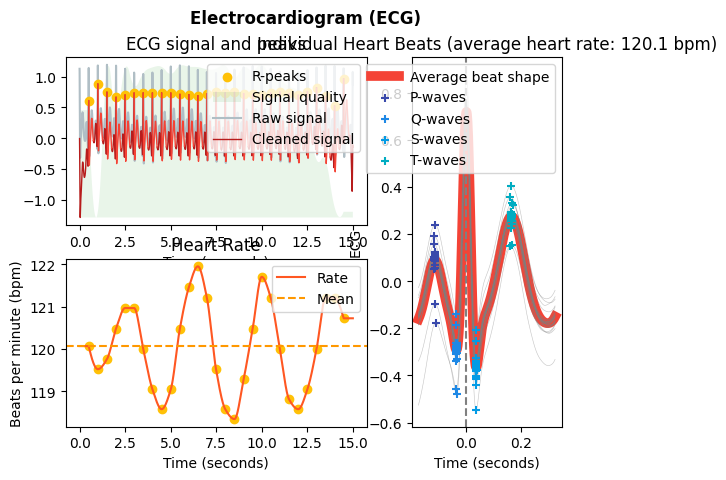

In [350]:
ecg = nk.ecg_simulate(duration=15, sampling_rate=1000, heart_rate=120)

# Preprocess ECG signal

signals, info = nk.ecg_process(ecg, sampling_rate=1000)
nk.ecg_plot(signals, info)

In [683]:
model_output = [-3.5442e-03, -2.9618e-03, -1.7939e-03, -1.0297e-03, -5.7915e-04,
          -4.9355e-04, -4.9688e-04, -4.3951e-04, -3.6091e-04, -3.2759e-04,
          -3.3375e-04, -3.8729e-04, -5.0462e-04, -5.4013e-04, -5.7628e-04,
          -5.7068e-04, -5.7444e-04, -3.6883e-04, -1.0403e-04,  2.0974e-04,
           5.6833e-04,  8.4715e-04,  9.9667e-04,  1.1518e-03,  1.1838e-03,
           1.1688e-03,  1.1484e-03,  1.1162e-03,  1.1269e-03,  1.1944e-03,
           1.2019e-03,  1.2036e-03,  1.1405e-03,  1.1159e-03,  1.1156e-03,
           1.1241e-03,  1.1551e-03,  1.2273e-03,  1.3510e-03,  1.3584e-03,
           1.3724e-03,  1.2832e-03,  1.2453e-03,  1.1232e-03,  9.9783e-04,
           8.2057e-04,  6.8254e-04,  5.4983e-04,  4.8647e-04,  3.8299e-04,
           3.2603e-04,  2.5469e-04,  1.7878e-04,  1.4732e-04,  5.0962e-05,
          -4.2457e-05, -9.7092e-05, -2.5834e-04, -4.3802e-04, -5.9325e-04,
          -6.2771e-04, -6.5711e-04, -6.8309e-04, -7.1499e-04, -6.8418e-04,
          -7.5825e-04, -8.4348e-04, -9.0887e-04, -1.0224e-03, -1.0270e-03,
          -9.7460e-04, -8.8295e-04, -7.6574e-04, -6.5954e-04, -5.9421e-04,
          -5.6423e-04, -6.0111e-04, -6.4330e-04, -7.4327e-04, -7.5969e-04,
          -7.5375e-04, -7.7225e-04, -7.1451e-04, -6.9590e-04, -7.0745e-04,
          -6.3154e-04, -6.2388e-04, -6.2086e-04, -6.8441e-04, -6.4331e-04,
          -6.3391e-04, -5.7298e-04, -5.8218e-04, -6.3461e-04, -7.0441e-04,
          -8.0977e-04, -8.3117e-04, -7.9336e-04, -7.8838e-04, -7.2410e-04,
          -5.1789e-04, -3.2219e-04, -7.2647e-05,  7.5508e-05,  1.3165e-04,
           2.0365e-04,  1.5870e-04,  7.1138e-05, -9.5915e-05, -1.9855e-04,
          -2.6188e-04, -3.0068e-04, -3.3664e-04, -2.7696e-04, -2.2836e-04,
          -8.4240e-05,  2.4490e-05,  1.0334e-04,  2.0914e-04,  3.6024e-04,
           6.0553e-04,  8.8160e-04,  1.0002e-03,  1.0515e-03,  9.6555e-04,
           8.8020e-04,  7.1759e-04,  6.1971e-04,  4.5715e-04,  3.4711e-04,
           2.6148e-04,  2.7427e-04,  3.0475e-04,  2.8748e-04,  2.5303e-04,
           1.4880e-04,  1.7434e-06, -2.2483e-04, -4.3410e-04, -5.9225e-04,
          -7.2318e-04, -7.7485e-04, -8.0059e-04, -7.6202e-04, -7.3005e-04,
          -7.5195e-04, -7.7362e-04, -8.0536e-04, -7.4547e-04, -7.3544e-04,
          -7.3636e-04, -8.0050e-04, -8.6598e-04, -9.1879e-04, -9.5794e-04,
          -8.9067e-04, -8.0458e-04, -7.0071e-04, -5.8834e-04, -4.9076e-04,
          -3.4135e-04, -2.6407e-04, -1.2559e-04, -5.1256e-05,  6.8016e-05,
           1.9360e-04,  2.4130e-04,  3.4615e-04,  3.2464e-04,  3.3347e-04,
           3.3204e-04,  4.5033e-04,  4.9723e-04,  6.4928e-04,  7.8289e-04,
           8.9478e-04,  1.1466e-03,  1.3819e-03,  1.6449e-03,  1.7026e-03,
           1.7042e-03,  1.6083e-03,  1.5097e-03,  1.3675e-03,  1.2275e-03,
           1.1325e-03,  1.0338e-03,  9.9663e-04,  1.0053e-03,  9.6096e-04,
           9.4341e-04,  8.2619e-04,  7.4360e-04,  6.4508e-04,  5.1195e-04,
           3.8242e-04,  2.1780e-04,  8.0716e-05, -5.7295e-05, -1.0860e-04,
          -6.8434e-05,  3.2920e-05,  1.6001e-04,  2.1810e-04,  2.8528e-04,
           3.8296e-04,  4.8799e-04,  5.1797e-04,  4.5221e-04,  3.1716e-04,
           1.6896e-04,  1.6885e-04,  1.4374e-04,  1.7295e-04,  1.9863e-04,
           1.9383e-04,  2.7394e-04,  2.6920e-04,  2.6375e-04,  2.1772e-04,
           1.4450e-04,  7.8984e-05, -3.6072e-05, -9.1355e-05, -1.1011e-04,
          -8.8900e-05,  4.1280e-05,  1.6093e-04,  2.3336e-04,  3.1793e-04,
           3.5895e-04,  5.4606e-04,  7.1957e-04,  7.7916e-04,  7.2536e-04,
           5.9093e-04,  4.1370e-04,  2.3042e-04,  1.6778e-04,  1.3472e-04,
           2.4801e-04,  4.2064e-04,  6.3153e-04,  9.3540e-04,  1.2540e-03,
           1.4920e-03,  1.6740e-03,  1.6802e-03,  1.6571e-03,  1.5285e-03,
           1.3044e-03,  1.1403e-03,  9.4694e-04,  7.4369e-04,  5.5071e-04,
           3.9127e-04,  3.1355e-04,  3.2533e-04,  3.1890e-04,  3.1187e-04,
           2.8332e-04,  2.1495e-04,  2.1614e-05, -1.8372e-04, -3.8425e-04,
          -5.8695e-04, -7.1355e-04, -7.3479e-04, -7.5674e-04, -7.3079e-04,
          -6.9893e-04, -6.2221e-04, -5.6299e-04, -5.4905e-04, -5.6539e-04,
          -6.5861e-04, -7.5204e-04, -8.3088e-04, -8.6407e-04, -9.3381e-04,
          -9.5197e-04, -1.0309e-03, -1.0791e-03, -1.0387e-03, -1.0313e-03,
          -9.0582e-04, -7.8706e-04, -7.4544e-04, -7.0727e-04, -7.5305e-04,
          -7.8509e-04, -7.9158e-04, -7.9613e-04, -7.4102e-04, -6.9664e-04,
          -6.4322e-04, -7.9803e-04, -1.5032e-03, -2.4914e-03, -3.3403e-03]

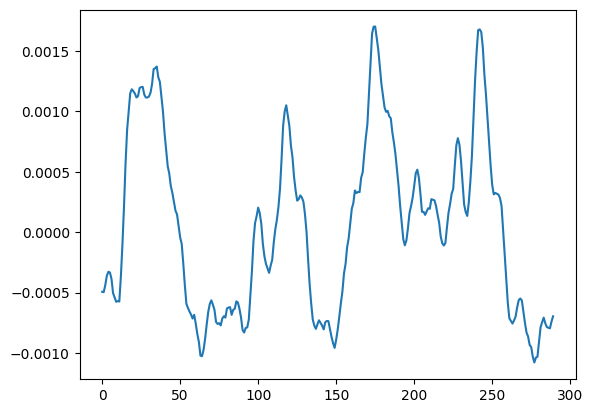

In [687]:
plt.plot(model_output[5:295])

In [571]:
True_hr = [123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123., 123.,
        123., 121., 121., 121., 121., 121., 121., 121., 121., 121., 121., 121.,
        121., 121., 121., 121., 121., 121., 121., 121., 121., 121., 121., 121.,
        121., 121., 121., 121., 121., 121., 121., 121., 121., 121., 120., 120.,
        120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
        120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
        120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
        120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
        120., 120., 120., 120., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119., 119.,
        119., 119., 119., 119., 119., 119., 118., 118., 118., 118., 118., 118.,
        118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118.,
        118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118.,
        118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118.,
        118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 118., 116.]

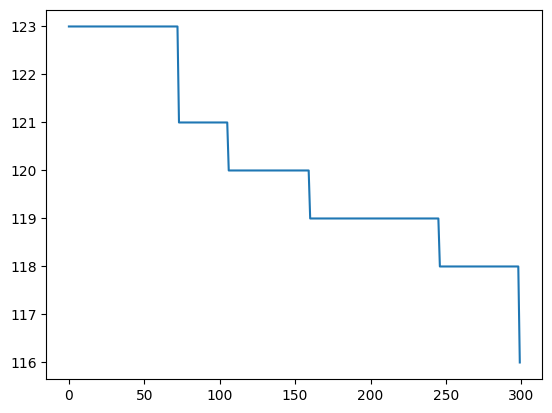

In [582]:
plt.plot(True_hr)

In [576]:
#model_output = (model_output-np.mean(model_output)) /np.std(model_output)

In [585]:
bpms

[375.0,
 250.00000000000003,
 166.66666666666666,
 214.2857142857143,
 166.66666666666666,
 62.50000000000001,
 136.36363636363637,
 300.0,
 500.00000000000006,
 375.0,
 375.0,
 107.14285714285715,
 83.33333333333333,
 166.66666666666666,
 125.00000000000001,
 300.0,
 83.33333333333333,
 750.0,
 136.36363636363637,
 187.5,
 78.94736842105263,
 214.2857142857143,
 750.0,
 88.23529411764707,
 107.14285714285715,
 150.0,
 93.75,
 100.0,
 214.2857142857143]

29

In [589]:
r_peaks = scipy.signal.find_peaks(model_output)[0]
bpms = [25/(r_peaks[i+1] - r_peaks[i])*60 for i in range(len(r_peaks)-1)]

#bpm = [frequencies[i]*60 for i in r_peaks]
edges = [r_peaks[0] + 0, 300 - r_peaks[-1]]
repeats = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks)-1)]
repeats[0] = repeats[0] + edges[0]
repeats[-1] = repeats[-1] + edges[1]
bpms = np.repeat(bpms, repeats)
len(bpms)




300

In [609]:
import heartpy as hp

In [700]:
hp.enhance_ecg_peaks(tmp_df[" ECG"], sample_rate=25)

ValueError: v cannot be empty

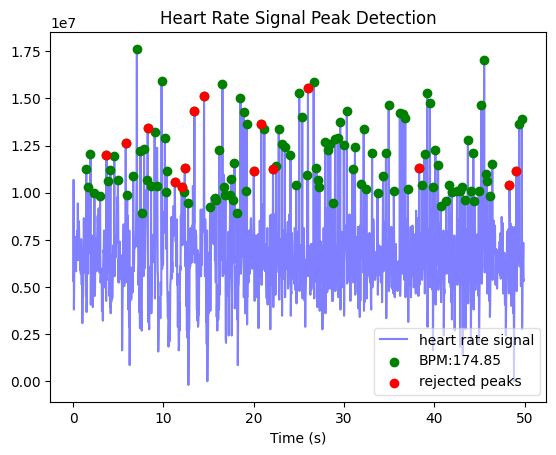

In [694]:
working_data, measures = hp.process(tmp_df[" ECG"].reset_index(drop=True), sample_rate=30)
hp.plotter(working_data=working_data, measures=measures)

In [649]:
measures['bpm']

122.7272727272727

In [631]:
working_data.keys()
#measures.keys()
#measures['hr']

dict_keys(['hr', 'sample_rate', 'peaklist', 'ybeat', 'rolling_mean', 'RR_list', 'RR_indices', 'RR_diff', 'RR_sqdiff', 'rrsd', 'best', 'removed_beats', 'removed_beats_y', 'binary_peaklist', 'RR_masklist', 'RR_list_cor', 'nn20', 'nn50', 'poincare'])

In [636]:
#r_peaks = working_data['peaklist']
r_peaks = [9, 24, 40, 123, 247, 261, 274]
bpms = [25/(r_peaks[i+1] - r_peaks[i])*60 for i in range(len(r_peaks)-1)]

#bpm = [frequencies[i]*60 for i in r_peaks]
edges = [r_peaks[0] + 0, 300 - r_peaks[-1]]
repeats = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks)-1)]
repeats[0] = repeats[0] + edges[0]
repeats[-1] = repeats[-1] + edges[1]
bpms = np.repeat(bpms, repeats)

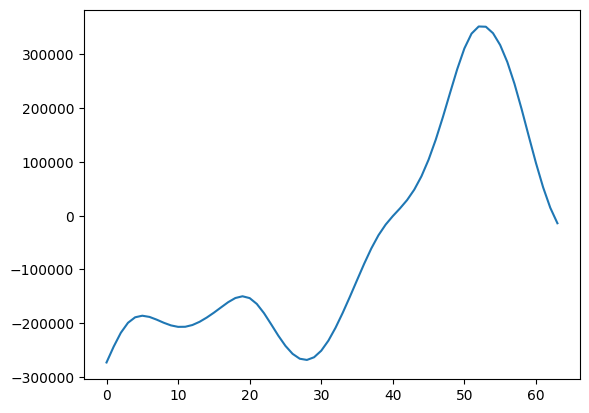

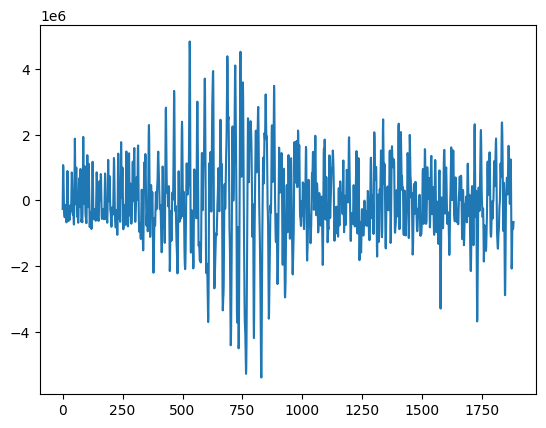

In [663]:
filtered = hp.filter_signal(ecg[" ECG"], cutoff = 5, sample_rate = 30, order = 3, filtertype='lowpass')
plt.plot(filtered)

({'hr': array([1.02400000e+03, 4.99401562e+02, 6.72077538e+01, 7.29571135e+00,
         7.30102194e-01, 3.85071227e-01, 3.95569368e-01, 2.42152333e-01,
         1.10103893e-01, 7.47352041e-02, 8.05172026e-02, 1.46000658e-01,
         4.20799050e-01, 5.52346277e-01, 7.15737088e-01, 6.88319044e-01,
         7.06639606e-01, 1.20091655e-01, 7.59657267e-04, 1.25571858e-02,
         6.77051078e-01, 3.34244957e+00, 6.40368807e+00, 1.14217747e+01,
         1.27449677e+01, 1.21111717e+01, 1.12875065e+01, 1.00737979e+01,
         1.04656623e+01, 1.32076214e+01, 1.35424985e+01, 1.36192808e+01,
         1.09801029e+01, 1.00629722e+01, 1.00521551e+01, 1.03620333e+01,
         1.15532358e+01, 1.47240901e+01, 2.16195789e+01, 2.20971642e+01,
         2.30223005e+01, 1.75955596e+01, 1.56070755e+01, 1.03288880e+01,
         6.43355263e+00, 2.94229288e+00, 1.40842604e+00, 5.93105946e-01,
         3.63446406e-01, 1.39623661e-01, 7.33217295e-02, 2.73044954e-02,
         6.62857862e-03, 3.05599382e-03, 4.36

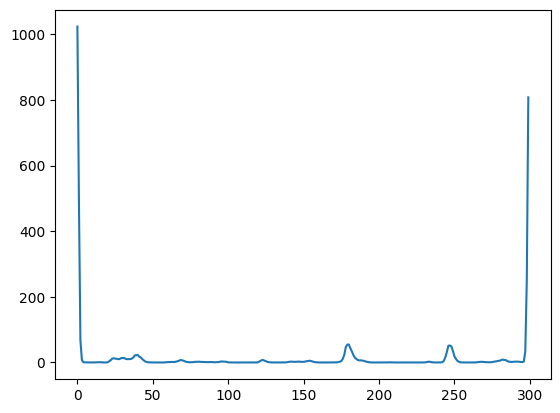

In [680]:
plt.plot(hp.enhance_peaks(model_output))
hp.process(hp.enhance_peaks(model_output), sample_rate=30)

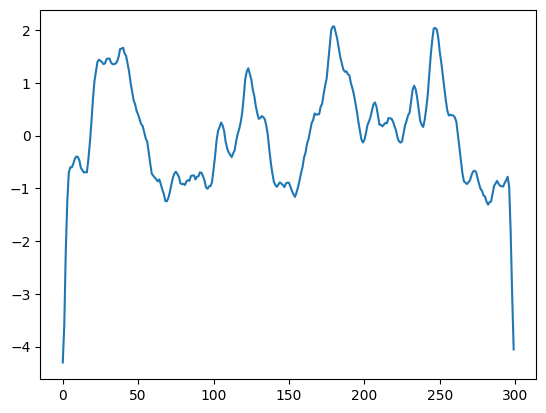

In [670]:
plt.plot(model_output)

In [701]:


# ERRORS
#RMSE, MAE, MAX, PCC, CCC, SNR = getErrors(bvps, fps, bpmES, bpmGT, timesES, timesGT)
#printErrors(RMSE, MAE, MAX, PCC, CCC, SNR)
#displayErrors(bpmES, bpmGT, timesES, timesGT)

ModuleNotFoundError: No module named 'pyVHR'

In [2]:
import pandas as pd
root_dir = "/work3/s174159/data/"
ecg_path = root_dir + "00/02/viatom-raw.csv"
index_path = root_dir + "00/02/c920.csv"

In [3]:
index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_sig"])
df = pd.read_csv(ecg_path)

lead_names = ["Lead I", "Lead II", "Lead III", "Lead aVR", "Lead aVL"]
df["Lead"] = lead_names * (len(df) // 5)
df["time"] = (df["milliseconds"] - df["milliseconds"].min()) / 1000  # Convert time.
index_df = pd.read_csv(index_path, header=None, names=["timestamp", "idx_signal"])
#df[" ECG"] = detrend_ecg(df[" ECG"], 300)

tmp_df = df[df["Lead"] == "Lead II"].loc[index_df.iloc[0].idx_signal+1:index_df.iloc[-1].idx_signal+1]

tmp_df[[' ECG', 'milliseconds']][300:600].to_csv('hi.csv')

In [4]:
tmp_df[[' ECG', 'milliseconds']].rename({'ECG':'ecg_measurement', 'milliseconds': 'timestamp'})

,ECG,milliseconds
1101,2621440,1523629938925
1106,2555904,1523629938965
1111,2097152,1523629939005
1116,2097152,1523629939046
1121,1376256,1523629939085
...,...,...
8571,917504,1523629998729
8576,-5046272,1523629998771
8581,-720896,1523629998811
8586,-65536,1523629998851


In [5]:
plt.plot(tmp_df[' ECG'][300:600])

NameError: name 'plt' is not defined

In [ ]:
from QRSDetectorOffline import QRSDetectorOffline

In [6]:
qrs_detector = QRSDetectorOffline(ecg_data_path="hi.csv", verbose=True,
                                  log_data=True, plot_data=True, show_plot=True)



ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [7]:
plt.plot(qrs_detector.differentiated_ecg_measurements)

NameError: name 'plt' is not defined

In [8]:
import numpy as np
r_peaks = [ 15,   41,   68,  120,  159,  203,  229,  267,  303,  340,  367,  404,  449,  479,
  510,  582,  615,  647,  674,  724,  750,  799,  824,  874,  913,  952,  981, 1019,
 1057, 1095, 1120, 1163, 1189, 1226, 1282, 1313, 1380, 1415, 1453, 1487]

In [9]:
bpms = [25/(r_peaks[i+1] - r_peaks[i])*60 for i in range(len(r_peaks)-1)]

#bpm = [frequencies[i]*60 for i in r_peaks]
edges = [r_peaks[0] + 0, 1499 - r_peaks[-1]]
repeats = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks)-1)]
repeats[0] = repeats[0] + edges[0]
repeats[-1] = repeats[-1] + edges[1]
bpms = np.repeat(bpms, repeats)
np.mean(bpms)

39.95650192134122

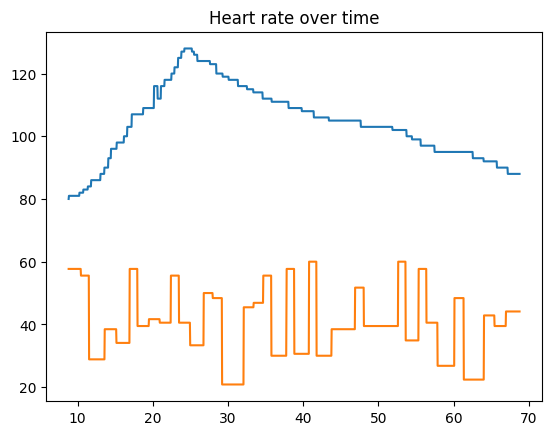

In [10]:
import matplotlib.pyplot as plt
plt.title("Heart rate over time")
plt.plot(tmp_df["time"], abs(tmp_df[" ECG HR"]))
plt.plot(tmp_df["time"], bpms)
plt.show()

In [11]:
qrs_detections = QRSDetectorOffline(ecg_data_path="hi.csv",
                                                    verbose=False, log_data=False, plot_data=False, show_plot=False).ecg_data_detected

local_hr_gt = qrs_detections[:, 2].sum() * (60.0 / 12)

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

In [12]:
local_hr_gt

NameError: name 'local_hr_gt' is not defined

In [13]:
qrs_detections[:, 2].sum() 

NameError: name 'qrs_detections' is not defined

In [16]:
fps = 30
window_length_s = 10
window_length = int(fps * window_length_s)

tmp_df = df[df["Lead"] == "Lead II"][' ECG'] #.loc[index_df.iloc[0].idx_signal+1:index_df.iloc[-1].idx_signal+1]
ecg_raw_data = tmp_df[index_df.iloc[0].idx_signal+1:index_df.iloc[0].idx_signal+window_length, 0:2]
#ecg_data_raw[ecg_idx[shift]:ecg_idx[shift + window_length], 0:2]

KeyError: 'key of type tuple not found and not a MultiIndex'

In [1]:
import os
from QRSDetectorOffline import QRSDetectorOffline
import numpy as np

class Dataset():
    PURE = 'pure'
    PURE_COMPRESSED = 'pure-compressed'
    ECG_FITNESS = 'ecg-fitness'
    HCI = 'hci'
    COHFACE = 'cohface'
    DB_NAMES = [PURE, PURE_COMPRESSED, ECG_FITNESS, HCI, COHFACE]
    DB_DICT = {PURE: '\\pur{}', PURE_COMPRESSED: '\\makecell{\\pur{}\\\\ {\\scriptsize MPEG-4 Visual}}', ECG_FITNESS: "\\ecf{}", HCI: "\\hci{}", COHFACE: "\\coh{}"}


class DatasetWorker(object):
    @staticmethod
    def prepare_list_of_files(hr_directory, db_name, subset='all', protocol='all'):
        if 'compressed' in db_name:
            db_name = db_name.split('-')[0]

        db_path = os.path.join(hr_directory, 'db', db_name)

        file = open(os.path.join(db_path, 'protocols', protocol, subset + '.txt'), 'r')
        return [file.replace('\n', '') for file in file.readlines()]

    @staticmethod
    def get_hr_directory():
        return os.path.join('data')

    @staticmethod
    def get_experiments_directory():
        return os.path.join(DatasetWorker.get_hr_directory(), 'experiments', 'cnn')

    @staticmethod
    def get_qf(db_name):
        qf = None
        if 'compressed' in db_name:
            qf = 23
        return qf

class ECGFitnessDatasetWorker(DatasetWorker):
    @staticmethod
    def load_ecg(basepath, camera_type, raw=True):
        if camera_type != 'c920' and camera_type != 'flir':
            raise Exception("Wrong camera type.")

        basepath = basepath.replace('/c920-0', '')
        basepath = basepath.replace('/c920-1', '')
        basepath = basepath.replace('/c920-2', '')
        basepath = basepath.replace('/flir', '')
        camera_csv_file_path = os.path.join(basepath, camera_type + '.csv')
        if not os.path.isfile(camera_csv_file_path):
            raise Exception("File %s does not exist." % camera_csv_file_path)

        viatom_raw_csv_file_path = os.path.join(basepath, 'viatom-raw.csv')
        if not os.path.isfile(viatom_raw_csv_file_path):
            raise Exception("File %s does not exist." % viatom_raw_csv_file_path)

        ecg_idxs = np.loadtxt(camera_csv_file_path, skiprows=0, delimiter=',')
        ecg_data_raw = np.loadtxt(viatom_raw_csv_file_path, skiprows=1, delimiter=',')

        if raw is not True:
            ecg_idxs = ecg_idxs[:, 1]
            ecg_data_raw = ecg_data_raw[:, 1]

        return ecg_data_raw, ecg_idxs

In [2]:
hr_directory = "/work3/s174159/data/"
root_dir = "/work3/s174159/data/"

ecg_data_raw, ecg_idx = ECGFitnessDatasetWorker.load_ecg(os.path.join(root_dir, "00/02/"), 'c920')
ecg_idx = ecg_idx[:, 1].astype('int32')

fps = 30
window_length_s = 10
window_length = int(fps * window_length_s)

In [3]:
qrs_detections = QRSDetectorOffline(ecg_data_path="",
                                                    ecg_data_raw=ecg_data_raw[ecg_idx[300]:ecg_idx[300 + window_length], 0:2],
                                                    verbose=False, log_data=False, plot_data=False, show_plot=False).ecg_data_detected

In [4]:
local_hr_gt = qrs_detections[:, 2].sum() * (60.0 / window_length_s)

In [25]:
qrs_detections

array([[1.52362995e+12, 1.96608000e+05, 0.00000000e+00],
       [1.52362995e+12, 2.62144000e+05, 0.00000000e+00],
       [1.52362995e+12, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.52362996e+12, 2.16268800e+06, 0.00000000e+00],
       [1.52362996e+12, 3.80108800e+06, 1.00000000e+00],
       [1.52362996e+12, 3.01465600e+06, 0.00000000e+00]])

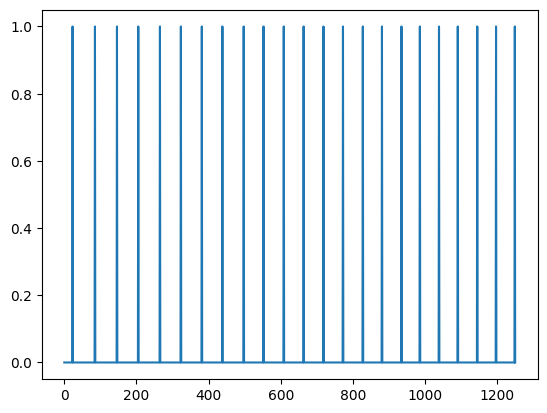

In [9]:
import matplotlib.pyplot as plt
plt.plot(qrs_detections[:, 2])